># 차량 공유업체의 차량 파손 여부 분류

# Import Libraries

In [ ]:
#!pip install --upgrade keras

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(530)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from tqdm.auto import tqdm

from sklearn.metrics import *
from skimage import exposure, filters, feature


from sklearn.model_selection import train_test_split
from keras.preprocessing import image

import keras
from keras import Model, Sequential
from keras import layers, models
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dropout
from keras.layers import Rescaling, RandomRotation, RandomTranslation, RandomZoom, RandomFlip

from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping


# Data Pre-Processing Step

## Data Load

1) 폴더별 이미지 데이터 수량 확인

In [ ]:
base_path = '/미니프로젝트04/Car_Images'
normal_path = os.path.join(base_path, 'normal')
abnormal_path = os.path.join(base_path, 'abnormal')

normal_cnt = len(os.listdir(normal_path))
abnormal_cnt = len(os.listdir(abnormal_path))

print(f"Normal : {normal_cnt}")
print(f"Abnormal : {abnormal_cnt}")

Normal : 302
Abnormal : 303


In [ ]:
def check_image(img_path):
    img_list = [os.path.join(img_path, f) for f in os.listdir(img_path)]
    
    selected_img = random.choice(img_list)
    
    image = Image.open(selected_img)
    
    print(f"Selected image path: {selected_img}")
    print(f"Image shape: {image.size}") # (너비, 높이) 형태로 출력됩니다.
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

2) 정상 차량 이미지 확인 및 형태 확인

In [ ]:
check_image(normal_path)

Selected image path: /Users/dkmoon/Desktop/KT_Aivle/교안/미니프로젝트04/Car_Images/normal/DALL·E 2023-03-10 18.52.35 - photo of a part of car.png
Image shape: (1024, 1024)


3) 파손 차량 이미지 확인 및 형태 확인

Selected image path: /Users/dkmoon/Desktop/KT_Aivle/교안/미니프로젝트04/Car_Images/abnormal/DALL·E 2023-03-11 14.49.59 - dents of a car.png
Image shape: (1024, 1024)


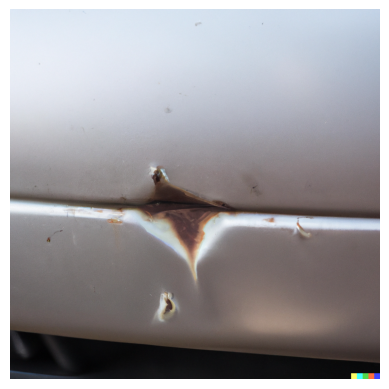

In [ ]:
check_image(abnormal_path)

## Data Pre-Processing

1) Create Target Class

In [ ]:
normal_cls_list = [0] * len(os.listdir(normal_path))
abnormal_cls_list = [1] * len(os.listdir(abnormal_path))

y = normal_cls_list.copy()
y.extend(abnormal_cls_list)

2) X Data List Merge

In [ ]:
normal_img_list = [os.path.join(normal_path, f) for f in os.listdir(normal_path)]
abnormal_img_list = [os.path.join(abnormal_path, f) for f in os.listdir(abnormal_path)]

x = normal_img_list.copy()
x.extend(abnormal_img_list)

3) Split Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.1,
                                                    random_state=530,
                                                    stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=.1,
                                                      random_state=530,
                                                      stratify=y_train)

4) Image to Array

In [ ]:
def load_and_transform_image(image_path, target_size=(128, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    return img_array

def create_datasets(X, y, target_size=(128, 128)):
    dataset = []
    for img_path, label in tqdm(zip(X, y)):
        img_array = load_and_transform_image(img_path, target_size)
        dataset.append([img_array, label])
    return np.array(dataset, dtype=object)

# NumPy 배열로 데이터셋 생성
train_dataset = create_datasets(X_train, y_train)
valid_dataset = create_datasets(X_valid, y_valid)
test_dataset = create_datasets(X_test, y_test)

0it [00:00, ?it/s]

489it [00:17, 28.54it/s]
55it [00:01, 29.10it/s]
61it [00:02, 29.62it/s]


In [ ]:
train_dataset[0][0].shape

(128, 128, 3)

## Data Augmentation

In [ ]:
def apply_augmentations(img_array):
    augmentations = []
    
    # Blur
    blur = cv2.blur(img_array, (5, 5))
    
    # Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(img_array, (5, 5), 0)
    
    # Sharpen
    kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen = cv2.filter2D(img_array, -1, kernel_sharpen)
    
    # Contrast Enhancement
    contrast = exposure.equalize_adapthist(img_array/255.0)
    contrast = np.clip(contrast * 255.0, 0, 255).astype('uint8')
    
    # Canny Edge Detection
    edges = cv2.Canny(img_array.astype(np.uint8), 100, 200)
    
    # Corner Detection (Harris Corner)
    gray = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    corners = cv2.dilate(corners, None)
    corners = np.stack((corners,)*3, axis=-1)  # 3채널 이미지로 변환
    
    # Add augmented images to list
    augmentations.extend([blur, gaussian_blur, sharpen, contrast, edges, corners])
    
    return augmentations

def augment_dataset(dataset):
    augmented_data = []
    for img_array, label in tqdm(dataset, total=len(dataset)):
        augmentations = apply_augmentations(img_array)
        for aug_img in augmentations:
            augmented_data.append([aug_img, label])
    return np.array(augmented_data, dtype=object)

augmented_train_dataset = augment_dataset(train_dataset)

100%|██████████| 489/489 [00:02<00:00, 218.86it/s]


In [ ]:
# train_dataset에서 임의의 이미지 하나를 선택
random_index = random.randint(0, len(train_dataset) - 1)
img_array, label = train_dataset[random_index][0], train_dataset[random_index][1]

# 선택된 이미지에 데이터 증강 적용
augmented_images = apply_augmentations(img_array)

# 원본 이미지와 증강된 이미지들을 시각화
fig, axes = plt.subplots(1, len(augmented_images) + 1, figsize=(20, 3))  # +1 for the original image

# 원본 이미지를 첫 번째 열에 표시
axes[0].imshow(img_array.astype('uint8'))
axes[0].set_title("Original")
axes[0].axis('off')

# 증강된 이미지들을 나머지 열에 표시
for i, aug_img in enumerate(augmented_images):
    axes[i + 1].imshow(aug_img.astype('uint8'))
    axes[i + 1].set_title(f"Aug {i+1}")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

## Data Save

In [ ]:
# 데이터셋 저장
base_path = '/미니프로젝트04/Car_Images_npy/dataset_224'
np.save(os.path.join(base_path, 'train_dataset.npy'), train_dataset)
np.save(os.path.join(base_path, 'augmented_train_dataset.npy'), augmented_train_dataset)
np.save(os.path.join(base_path, 'valid_dataset.npy'), valid_dataset)
np.save(os.path.join(base_path, 'test_dataset.npy'), test_dataset)

# CNN Modeling Step

## Data Load

In [ ]:
train_aug_path = '/미니프로젝트04/Car_Images_npy/dataset_224/augmented_train_dataset.npy'
train_path = '/미니프로젝트04/Car_Images_npy/dataset_224/train_dataset.npy'
valid_path = '/미니프로젝트04/Car_Images_npy/dataset_224/valid_dataset.npy'
test_path = '/미니프로젝트04/Car_Images_npy/dataset_224/test_dataset.npy'

In [ ]:
train_aug = np.load(train_aug_path, allow_pickle=True)
train = np.load(train_path, allow_pickle=True)
valid = np.load(valid_path, allow_pickle=True)
test = np.load(test_path, allow_pickle=True)

In [ ]:
print(f"Aug Train Data : {train_aug.shape}")
print(f"Train Data : {train.shape}")
print(f"Valid Data : {valid.shape}")
print(f"Test Data : {test.shape}")

Aug Train Data : (2934, 2)
Train Data : (489, 2)
Valid Data : (55, 2)
Test Data : (61, 2)


In [ ]:
def convert_to_3_channels(image):
    """2차원 이미지를 입력받아 3차원 이미지로 변환"""
    if len(image.shape) == 2:  # 이미지가 2차원인 경우
        image = np.stack((image,)*3, axis=-1)  # 같은 이미지를 3번 쌓아 3차원으로 변환
    return image

# train_aug 데이터셋 변환
train_aug_converted = [(convert_to_3_channels(img), label) for img, label in train_aug]

In [ ]:
# Augmented Train 데이터셋에서 X와 y 분리
X_train_aug = np.stack([item[0] for item in train_aug_converted], axis=0)
y_train_aug = np.array([item[1] for item in train_aug_converted])

# Valid 데이터셋에서 X와 y 분리
X_valid = np.stack([item[0] for item in valid], axis=0)
y_valid = np.array([item[1] for item in valid])

# Test 데이터셋에서 X와 y 분리
X_test = np.stack([item[0] for item in test], axis=0)
y_test = np.array([item[1] for item in test])

# 이미지 데이터 정규화
X_train_aug = X_train_aug.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## Modeling

### Model 1 - CNN

In [ ]:
def cnn_model_1():
    model = Sequential([
        RandomRotation(factor=(-0.3,0.3)),
        RandomFlip(mode='horizontal_and_vertical'),

        # Convolution + BatchNormalization
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),

        # Convolution + BatchNormalization
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),

        # MaxPooling + Dropout
        MaxPooling2D(pool_size=(2, 2)),

        # Convolution + BatchNormalization
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),

        # Convolution + BatchNormalization
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),

        # MaxPooling + Dropout
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten
        Flatten(),

        # Fully Connected Layer + BatchNormalization
        Dense(512, activation='relu'),
        # BatchNormalization(),
        Dense(128, activation='relu'),

        # 16. 아웃풋 레이어
        Dense(1, activation='sigmoid')  # 이진 분류를 위한 설정
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',  # 이진 분류를 위한 손실 함수
                metrics=['accuracy'])
    return model

cnn_1 = cnn_model_1()
cnn_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_1 (RandomRotation)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model 1 - ResNet

In [ ]:
# ResNet 블록 정의
def resnet_block(input_tensor, filters, strides=(1, 1)):
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    if strides != (1, 1):
        shortcut = Conv2D(filters, (1, 1), strides=strides)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet50 모델 구성
def resnet50(input_shape, num_classes=1):  # num_classes 기본값을 1로 설정
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=(2, 2))
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=(2, 2))
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=(2, 2))
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='sigmoid')(x)  # 활성화 함수를 'sigmoid'로 변경

    model = Model(inputs=inputs, outputs=x)

    # 모델 컴파일, 손실 함수를 'binary_crossentropy'로 변경
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
input_shape = (224, 224, 3)
resnet_model = resnet50(input_shape)

### Model 1 - EfficientNet

In [ ]:
def SEBlock(input_feature, ratio=4):
    """Squeeze and Excitation Block."""
    channel_axis = -1
    filters = input_feature.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_feature)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)

    return layers.multiply([input_feature, se])

def MBConvBlock(inputs, filters, kernel_size, strides, expand_ratio):
    """Mobile Inverted Bottleneck Convolution Block with Squeeze and Excitation Block."""
    channel_axis = -1
    input_filters = inputs.shape[channel_axis]
    expanded_filters = input_filters * expand_ratio

    x = inputs

    if expand_ratio != 1:
        x = layers.Conv2D(expanded_filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization(axis=channel_axis)(x)
        x = layers.Activation(tf.nn.swish)(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(axis=channel_axis)(x)
    x = layers.Activation(tf.nn.swish)(x)

    x = SEBlock(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(axis=channel_axis)(x)

    if strides == 1 and input_filters == filters:
        x = layers.Add()([x, inputs])

    return x

def EfficientNetB4(input_shape=(380, 380, 3), dropout_rate=0.4, classes=1):
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(48, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.swish)(x)

    # MBConv blocks for B4
    x = MBConvBlock(x, filters=24, kernel_size=3, strides=1, expand_ratio=1)
    x = MBConvBlock(x, filters=24, kernel_size=3, strides=1, expand_ratio=1)
    x = MBConvBlock(x, filters=48, kernel_size=3, strides=2, expand_ratio=6)
    x = MBConvBlock(x, filters=48, kernel_size=3, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=48, kernel_size=3, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=88, kernel_size=3, strides=2, expand_ratio=6)
    x = MBConvBlock(x, filters=88, kernel_size=3, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=120, kernel_size=5, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=120, kernel_size=5, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=208, kernel_size=5, strides=2, expand_ratio=6)
    x = MBConvBlock(x, filters=208, kernel_size=5, strides=1, expand_ratio=6)
    x = MBConvBlock(x, filters=208, kernel_size=5, strides=1, expand_ratio=6)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
eff_model_b4 = EfficientNetB4()
eff_model_b4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
eff_model_b4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 380, 380, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 190, 190, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 190, 190, 48)   │            192 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 190, 190, 48)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 190, 190, 48)   │            432 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 190, 190, 48)   │            192 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 190, 190, 48)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 48)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 48)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 12)       │            588 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 48)       │            624 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 190, 190, 48)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 190, 190, 24)   │          1,152 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 190, 190, 24)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 190, 190, 24)   │            216 │ batch_normalization_2… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 190, 190, 24)   │             96 │ depthwise_conv2d_1[0]… │
│ (BatchNormalization) 

 Total params: 4,436,095 (16.92 MB)

 Trainable params: 4,409,391 (16.82 MB)

 Non-trainable params: 26,704 (104.31 KB)

## Training

### Efficient Training

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30,
                               verbose=1, mode='min', restore_best_weights=True)

# 모델 훈련
history_eff_b4 = eff_model_b4.fit(X_train_aug, y_train_aug,
                    validation_data=(X_valid, y_valid),
                    epochs=100,  # 최대 에폭 수
                    batch_size=32,  # 배치 크기
                    callbacks=[early_stopping])  # 콜백 추가

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.5911 - loss: 1.1145 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - accuracy: 0.6980 - loss: 0.5871 - val_accuracy: 0.5091 - val_loss: 0.6953
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.7247 - loss: 0.5202 - val_accuracy: 0.5091 - val_loss: 0.6927
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.7455 - loss: 0.4951 - val_accuracy: 0.5091 - val_loss: 0.6902
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.7614 - loss: 0.4651 - val_accuracy: 0.5091 - val_loss: 0.6739
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 459ms/step - accuracy: 0.7733 - loss: 0.4377 - val_accuracy: 0.8000 - val_loss: 0.4328
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - accuracy: 0.8056 - loss: 0.3754 - val_accuracy: 0.7636 - val_loss: 0.4366
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.8063 - loss: 0.3748 - va

### CNN Training

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=40,
                               verbose=1, mode='min', restore_best_weights=True)

# 모델 훈련
history_cnn = cnn_1.fit(X_train_aug, y_train_aug,
                    validation_data=(X_valid, y_valid),
                    epochs=100,  # 최대 에폭 수
                    batch_size=32,  # 배치 크기
                    callbacks=[early_stopping])  # 콜백 추가

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.5991 - loss: 21.4644 - val_accuracy: 0.5636 - val_loss: 1.4051
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.6120 - loss: 6.6019 - val_accuracy: 0.5091 - val_loss: 14.2753
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.6380 - loss: 2.8984 - val_accuracy: 0.6182 - val_loss: 3.2028
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.6939 - loss: 0.9837 - val_accuracy: 0.5273 - val_loss: 4.0634
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.7438 - loss: 0.6743 - val_accuracy: 0.5455 - val_loss: 1.6733
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.7299 - loss: 0.5452 - val_accuracy: 0.7818 - val_loss: 0.5692
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.7584 - loss: 0.4957 - val_accuracy: 0.9091 - val_loss: 0.3784
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.7539 - loss: 0.4733 

### ResNet Training

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30,
                               verbose=1, mode='min', restore_best_weights=True)

# 모델 훈련
history_res = resnet_model.fit(X_train_aug, y_train_aug,
                           validation_data=(X_valid, y_valid),
                           epochs=100,  # 최대 에폭 수
                           batch_size=32,  # 배치 크기
                           callbacks=[early_stopping])  # 콜백 추가

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 327ms/step - accuracy: 0.5856 - loss: 1.2297 - val_accuracy: 0.4000 - val_loss: 85.2134
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.6488 - loss: 0.6015 - val_accuracy: 0.5273 - val_loss: 6.2276
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.7330 - loss: 0.5321 - val_accuracy: 0.6182 - val_loss: 0.9111
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6996 - loss: 0.5358 - val_accuracy: 0.8000 - val_loss: 0.9624
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7382 - loss: 0.5093 - val_accuracy: 0.5455 - val_loss: 1.0766
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7443 - loss: 0.4845 - val_accuracy: 0.4909 - val_loss: 0.9465
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7544 - loss: 0.4689 - val_accuracy: 0.5273 - val_loss: 0.7583
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7516 - loss: 0.4582 - val_accuracy:

## Train History Visualize

### CNN History

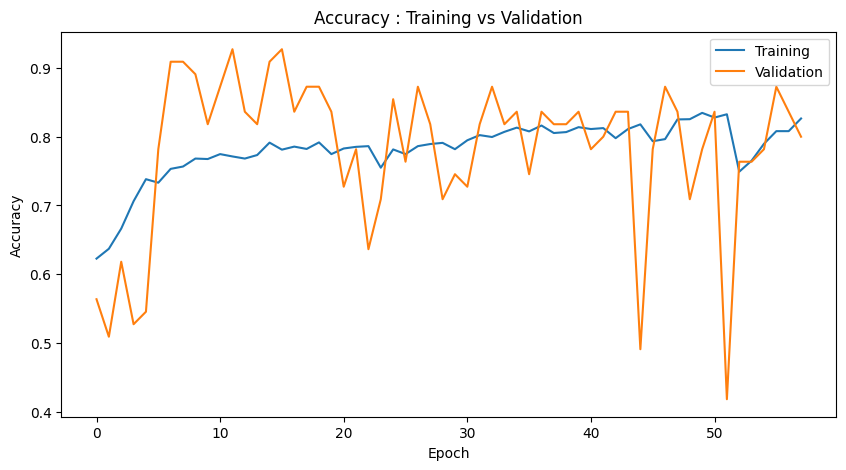

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

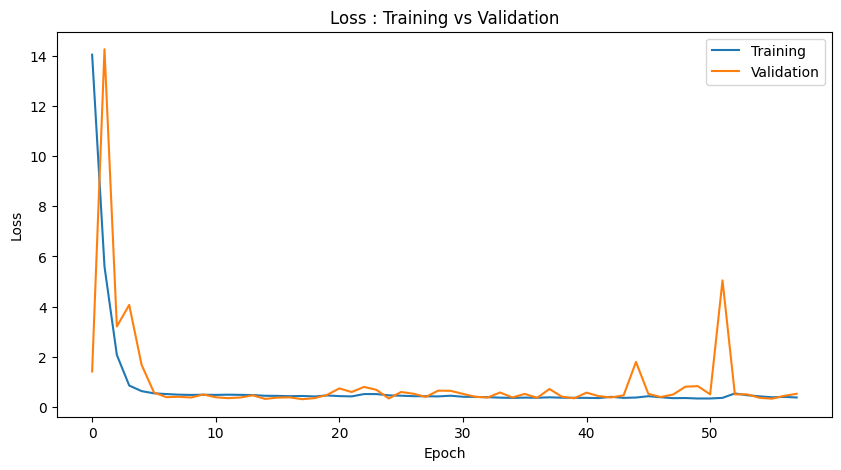

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

### ResNet History

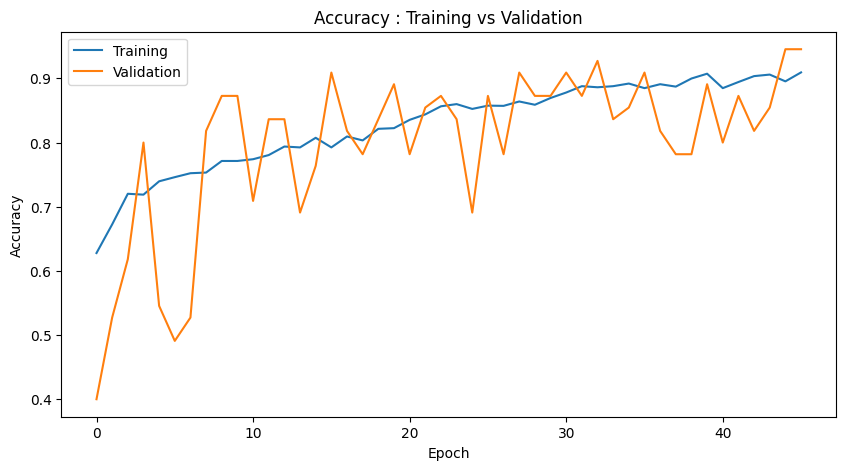

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

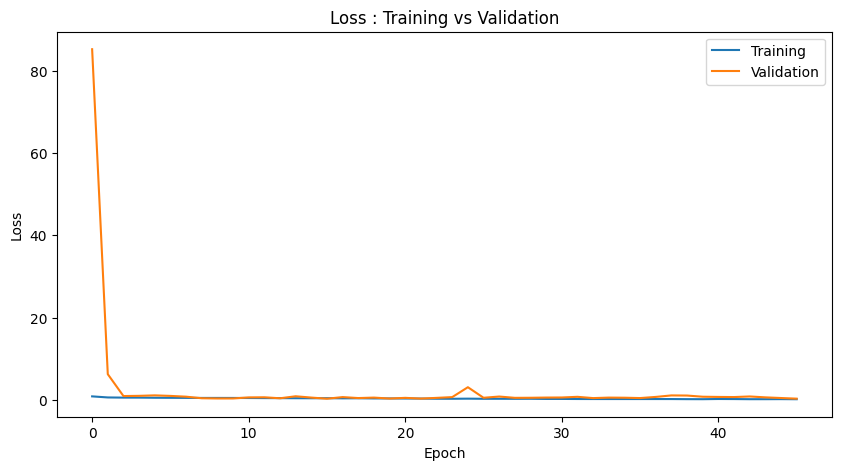

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

### Efficient History

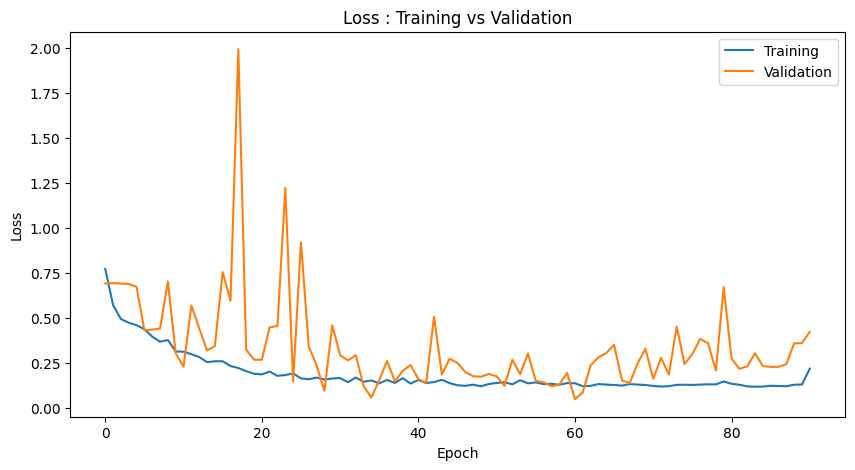

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_eff_b4.history['loss'])
plt.plot(history_eff_b4.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

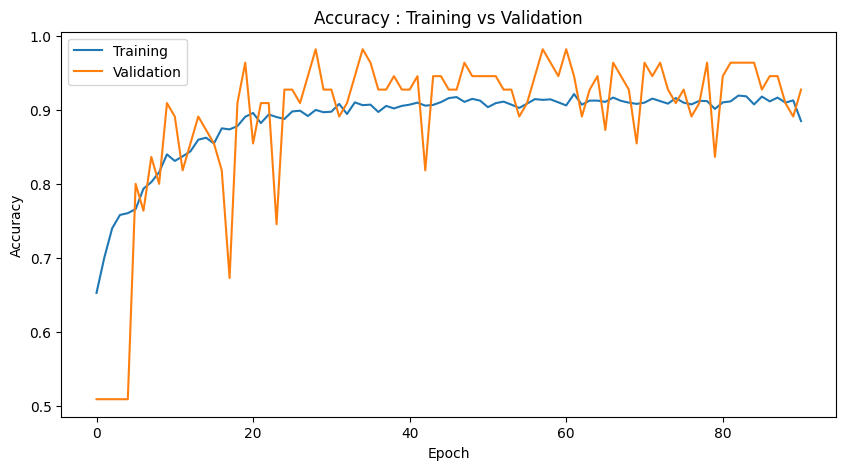

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_eff_b4.history['accuracy'])
plt.plot(history_eff_b4.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## Predict

### ResNet Predict

In [ ]:
# 테스트 데이터셋에서 X와 y 분리 및 정규화
X_test = np.stack([item[0] for item in test], axis=0)
y_test = np.array([item[1] for item in test])
X_test = X_test.astype('float32') / 255.0

# 모델을 사용하여 테스트 데이터셋에 대한 추론 수행
predictions = resnet_model.predict(X_test)
predictions_binary = (predictions > 0.5).astype("int32")

# 모델의 성능 평가
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print('='*60)
print(confusion_matrix(y_test, predictions_binary))
print('='*60)
print(classification_report(y_test, predictions_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step
Accuracy: 0.7705
Precision: 0.7297
Recall: 0.8710
F1 Score: 0.7941
[[20 10]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.73      0.87      0.79        31

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61



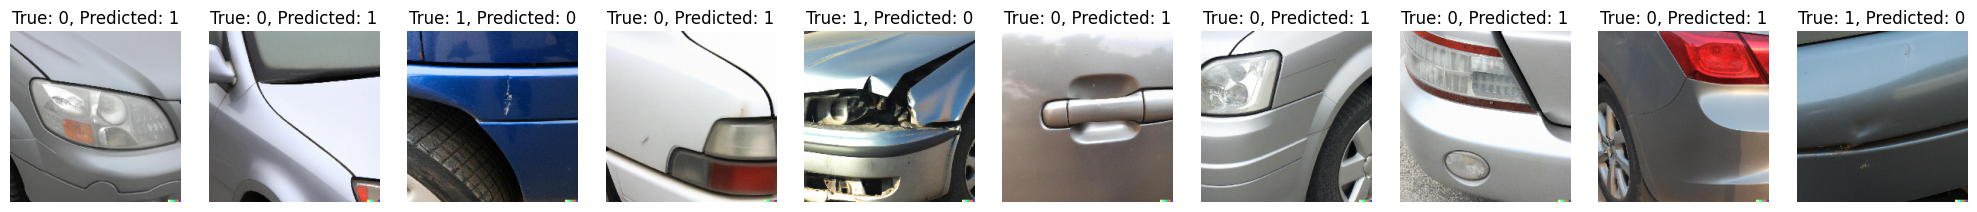

In [ ]:
# y_test를 정수형으로 변환
y_test_int = y_test.flatten().astype(int)

# 예측 결과와 실제 결과가 다른 경우의 인덱스 찾기
misclassified_indices = np.where(predictions_binary.flatten() != y_test_int)[0]

# 예측을 틀린 이미지들 중 최대 10개까지만 시각화
num_images_to_show = min(len(misclassified_indices), 10)

if num_images_to_show > 0:
    plt.figure(figsize=(20, 4))
    for i, index in enumerate(misclassified_indices[:num_images_to_show]):
        ax = plt.subplot(2, num_images_to_show, i+1)
        ax.imshow(X_test[index])
        ax.set_title(f"True: {y_test_int[index]}, Predicted: {predictions_binary[index][0]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("모든 예측이 정확합니다.")

### Efficient Predict

In [ ]:
# 모델을 사용하여 테스트 데이터셋에 대한 추론 수행
predictions = eff_model_b4.predict(X_test)
predictions_binary = (predictions > 0.5).astype("int32")
# predictions = np.round(predictions).astype(int)  # 이진 분류 결과를 반올림하여 정수형으로 변환

# 모델의 성능 평가
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print('='*60)
print(confusion_matrix(y_test, predictions_binary))
print('='*60)
print(classification_report(y_test, predictions_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 25s/step
Accuracy: 0.9016
Precision: 0.9310
Recall: 0.8710
F1 Score: 0.9000
[[28  2]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.93      0.87      0.90        31

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [ ]:
# y_test를 정수형으로 변환
y_test_int = y_test.flatten().astype(int)

# 예측 결과와 실제 결과가 다른 경우의 인덱스 찾기
misclassified_indices = np.where(predictions_binary.flatten() != y_test_int)[0]

# 예측을 틀린 이미지들 중 최대 10개까지만 시각화
num_images_to_show = min(len(misclassified_indices), 10)

if num_images_to_show > 0:
    plt.figure(figsize=(20, 4))
    for i, index in enumerate(misclassified_indices[:num_images_to_show]):
        ax = plt.subplot(2, num_images_to_show, i+1)
        ax.imshow(X_test[index])
        ax.set_title(f"True: {y_test_int[index]}, Predicted: {predictions_binary[index][0]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("모든 예측이 정확합니다.")

### CNN Predict

In [ ]:
# 테스트 데이터셋에서 X와 y 분리 및 정규화
X_test = np.stack([item[0] for item in test], axis=0)
y_test = np.array([item[1] for item in test])
X_test = X_test.astype('float32') / 255.0

# 모델을 사용하여 테스트 데이터셋에 대한 추론 수행
predictions = cnn_1.predict(X_test)
predictions_binary = (predictions > 0.5).astype("int32")

# 모델의 성능 평가
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print('='*60)
print(confusion_matrix(y_test, predictions_binary))
print('='*60)
print(classification_report(y_test, predictions_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy: 0.8197
Precision: 0.8125
Recall: 0.8387
F1 Score: 0.8254
[[24  6]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.84      0.83        31

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [ ]:
# y_test를 정수형으로 변환
y_test_int = y_test.flatten().astype(int)

# 예측 결과와 실제 결과가 다른 경우의 인덱스 찾기
misclassified_indices = np.where(predictions_binary.flatten() != y_test_int)[0]

# 예측을 틀린 이미지들 중 최대 10개까지만 시각화
num_images_to_show = min(len(misclassified_indices), 10)

if num_images_to_show > 0:
    plt.figure(figsize=(20, 4))
    for i, index in enumerate(misclassified_indices[:num_images_to_show]):
        ax = plt.subplot(2, num_images_to_show, i+1)
        ax.imshow(X_test[index])
        ax.set_title(f"True: {y_test_int[index]}, Predicted: {predictions_binary[index][0]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("모든 예측이 정확합니다.")

# Transfer Learning Step

## Create Dataset

In [ ]:
# 상위 디렉토리 경로 설정
dataset_dir = './Car_Images'

full_dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(299, 299),
    shuffle=True,
    seed=530,
)

# 데이터셋 크기 계산
DATASET_SIZE = full_dataset.cardinality().numpy()

# 학습, 검증, 테스트 분할 비율 설정
TRAIN_SIZE = int(0.7 * DATASET_SIZE)
VAL_SIZE = int(0.1 * DATASET_SIZE)
TEST_SIZE = int(0.2 * DATASET_SIZE)

# 데이터셋 분할
train_dataset = full_dataset.take(TRAIN_SIZE)
test_dataset = full_dataset.skip(TRAIN_SIZE)
val_dataset = test_dataset.skip(TEST_SIZE)
test_dataset = test_dataset.take(TEST_SIZE)

# 데이터셋 확인
print(f"Train Dataset Size: {train_dataset.cardinality().numpy()}")
print(f"Validation Dataset Size: {val_dataset.cardinality().numpy()}")
print(f"Test Dataset Size: {test_dataset.cardinality().numpy()}")

Found 605 files belonging to 2 classes.
Train Dataset Size: 13
Validation Dataset Size: 3
Test Dataset Size: 3


## Inception Model Transfer Learning

In [ ]:
# InceptionV3 모델 불러오기
base_model = InceptionV3(input_shape=(299, 299, 3),
                         include_top=False,
                         weights='imagenet')
# base_model.trainable = False  # 모델 가중치 고정

# 모델 구조 설계
model = Sequential([
    Rescaling(1./255),
    # 이미지 증강 레이어
    RandomRotation(factor=(-0.3,0.3)),
    RandomFlip(mode='horizontal_and_vertical'),

    # InceptionV3 베이스 모델
    base_model,

    # 추가 레이어
    GlobalAveragePooling2D(),
    # Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ ?                           │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30,
                               verbose=1, mode='min', restore_best_weights=True)

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 256s 14s/step - accuracy: 0.7715 - loss: 0.5835 - val_accuracy: 0.4624 - val_loss: 75.0602
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 524ms/step - accuracy: 0.8975 - loss: 0.3146 - val_accuracy: 0.4624 - val_loss: 6.9667
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 537ms/step - accuracy: 0.9124 - loss: 0.2274 - val_accuracy: 0.4194 - val_loss: 5.4168
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - accuracy: 0.9389 - loss: 0.1654 - val_accuracy: 0.5484 - val_loss: 185.9389
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - accuracy: 0.9265 - loss: 0.2141 - val_accuracy: 0.5699 - val_loss: 34.2440
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.9160 - loss: 0.1941 - val_accuracy: 0.7957 - val_loss: 0.6770
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 0.9418 - loss: 0.1379 - val_accuracy: 0.5806 - val_loss: 2.6866
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 516ms/step - accuracy: 0.9290 - loss: 0.1805 - val_

### Train Result Visualize

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

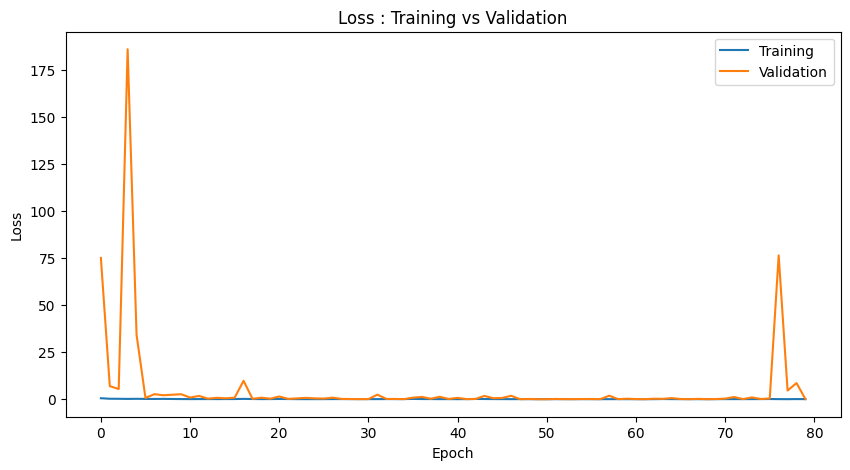

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## Predict

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Accuracy: 0.9896
Precision: 1.0000
Recall: 0.9815
F1 Score: 0.9907


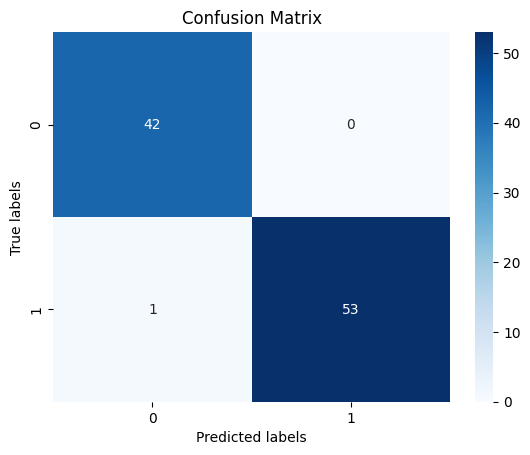

In [ ]:
# test_dataset으로부터 X_test와 y_test 분리
X_test = []
y_test = []
for x, y in test_dataset:
    X_test.append(x.numpy())  # Dataset에서 X 값을 가져와 NumPy 배열로 변환
    y_test.append(y.numpy())  # Dataset에서 y 값을 가져와 NumPy 배열로 변환

# 리스트를 NumPy 배열로 변환
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# 모델 예측
predictions = model.predict(X_test)

# 예측 결과를 이진 레이블로 변환
predictions_binary = (predictions > 0.5).astype("int32")

# 성능 평가
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, predictions_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()